1. **Feature detection (extraction) stage**:
  
  - each image is searched for locations that are likely to match well in other images.
  
2. **Feature description stage**:
  
  - each region around detected keypoint locations is converted into a more com- pact and stable (invariant) descriptor that can be matched against other descriptors
  
3. **Feature matching stage**:
  
  - searches for likely matching candidates in other images.
  
4. **Feature tracking stage**:
  
  - is an alternative to the third stage that only searches a small neighborhood around each detected feature and is therefore more suitable for video processing.

## 3. SIFT (Scale-Invariant Feature Transform)

SIFT detects keypoints and computes descriptors, which are invariant to scale and rotation. The steps involve:
1. `Detecting scale-space extrema`:
- SIFT algorithm uses Difference of Gaussians which is an approximation of LoG (Laplacian of Gaussian). Difference of Gaussian is obtained as the difference of Gaussian blurring of an image with two different σ, let it be σ and kσ. This process is done for different octaves of the image in Gaussian Pyramid.
- Once this DoG are found, images are searched for local extrema over scale and space. For eg, one pixel in an image is compared with its 8 neighbours as well as 9 pixels in next scale and 9 pixels in previous scales. If it is a local extrema, it is a potential keypoint. It basically means that keypoint is best represented in that scale.

2. `Keypoint localization and filtering`:

- Taylor series expansion of scale space is used to get more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected.
- DoG has higher response for edges, so edges also need to be removed. For this, a concept similar to Harris corner detector is used. So it eliminates any low-contrast keypoints and edge keypoints and what remains is strong interest points.

3. `Assigning orientation and computing descriptors`:

    Now an orientation is assigned to each keypoint to achieve invariance to image rotation

 - neighbourhood is taken around the keypoint location depending on the scale, and the gradient magnitude and direction is calculated in that region.
 - An orientation histogram with 36 bins covering 360 degrees is created (It is weighted by gradient magnitude and gaussian-weighted circular window with σ equal to 1.5 times the scale of keypoint).
 - The highest peak in the histogram is taken and any peak above 80% of it is also considered to calculate the orientation.
 - It creates keypoints with same location and scale, but different directions. It contribute to stability of matching.
 
4. `Keypoint Matching`:

  - Keypoints between two images are matched by identifying their nearest neighbours.
  - But in some cases, the second closest-match may be very near to the first. It may happen due to noise or some other reasons. In that case, `ratio of closest-distance to second-closest distance` is taken. If it is greater than 0.8, they are rejected. It eliminates around 90% of false matches while discards only 5% correct matches, as per the paper.

References:
- https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
- https://en.wikipedia.org/wiki/Scale-invariant_feature_transform

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

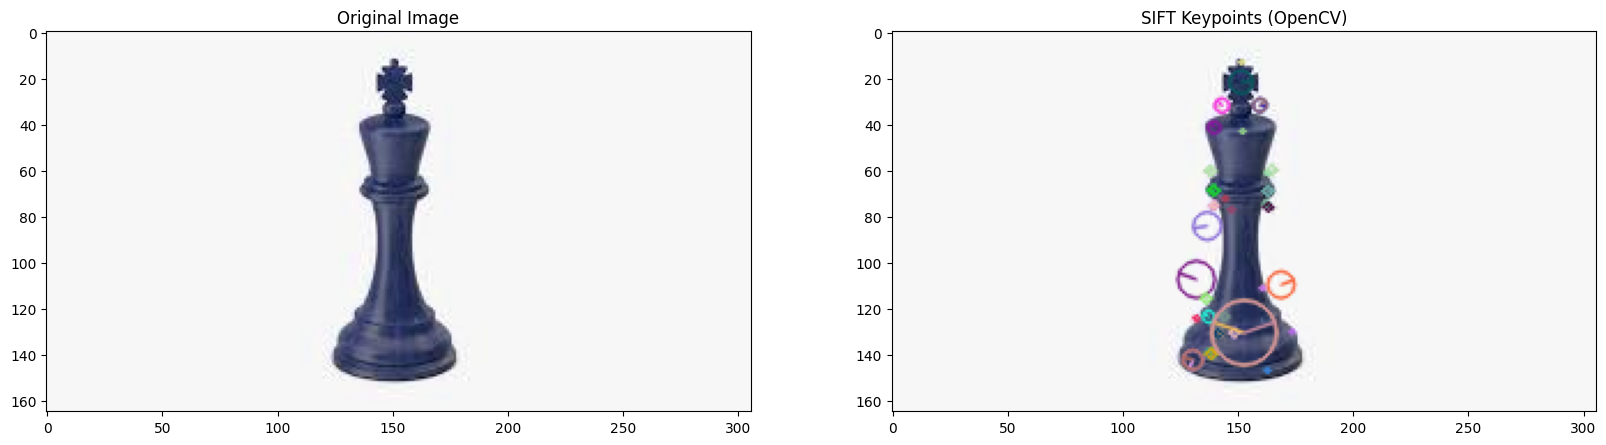

In [4]:
# OpenCV Implementation
img = cv.imread('assets/king.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Create SIFT detector
sift = cv.SIFT_create()
# Detect keypoints and descriptors
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Draw keypoints on the image
img_with_keypoints = cv.drawKeypoints(img, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_img = cv.drawKeypoints(img, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Displaying using matplotlib
plt.figure(figsize=(20, 18)) 
plt.subplot(121),plt.imshow(img,'gray')
plt.title('Original Image')
plt.subplot(122),plt.imshow(img_with_keypoints, cmap='gray')
plt.title('SIFT Keypoints (OpenCV)')
plt.show()

In [5]:
print(f'The no of keypoints:{len(keypoints)}')
print(f'The shape of descriptor:{descriptors.shape})')

print("Visualise Randow idx")
print(descriptors[0])

The no of keypoints:43
The shape of descriptor:(43, 128))
Visualise Randow idx
[ 11.   6.   5.  11.   2.   6.  10.  21. 129.  69.   0.   0.   1.  12.
  19.  10. 163. 133.   0.   0.   0.   0.   0.   1.  17.   7.   0.   0.
   0.   0.   0.   0.   2.   0.   0.   0.   0.  34. 124.  33.  79.  13.
   1.   4.   1.  22.  76.  32. 163.  57.   0.   0.   0.   0.  10.  65.
  54.   6.   0.   0.   0.   0.   0.   4.   0.   0.   0.   0.   0. 109.
 163.   0.  10.   0.   0.   1.   0.  56. 163.  75. 102.   1.   0.   0.
   0.   0.  99. 163.  19.   0.   0.   0.   0.   0.   0.  14.   0.   0.
   0.   0.   0.   9.  25.   0.   0.   0.   0.   0.   0.   5.  62.   7.
   0.   0.   0.   0.   0.   0.  20.  16.   0.   0.   0.   0.   0.   0.
   0.   1.]


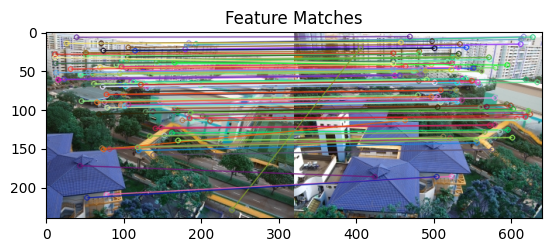

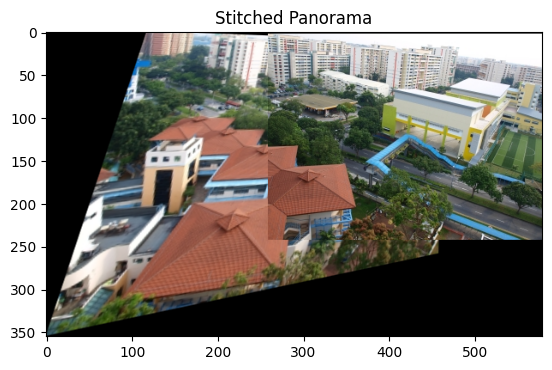

In [6]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class PanoramaStitcher:
    def __init__(self):
        # Initialize SIFT detector
        self.sift = cv.SIFT_create()

    def detect_and_compute(self, img):
        """
        Detect keypoints and compute descriptors for the given image.
        """
        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Detect keypoints and compute descriptors
        keypoints, descriptors = self.sift.detectAndCompute(gray, None)
        
        # Return keypoints and descriptors
        return keypoints, descriptors

    def match_features(self, descriptors1, descriptors2):
        """
        Match features between two sets of descriptors.
        """
        # Initialize BFMatcher with default parameters
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

        # Match descriptors
        matches = bf.match(descriptors1, descriptors2)

        # Sort them in the order of their distance (best matches first)
        matches = sorted(matches, key=lambda x: x.distance)

        return matches

    def stitch_images(self, img1, img2):
        """
        Stitch two images together based on feature matching.
        """
        # Detect and compute keypoints and descriptors for both images
        keypoints1, descriptors1 = self.detect_and_compute(img1)
        keypoints2, descriptors2 = self.detect_and_compute(img2)

        # Match features between the two sets of descriptors
        matches = self.match_features(descriptors1, descriptors2)

        # Visualize matches between the two images
        img_matches = cv.drawMatches(img1, keypoints1, img2, keypoints2, matches[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img_matches)
        plt.title("Feature Matches")
        plt.show()

        # Extract location of good matches (keypoints from both images)
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Calculate the Homography matrix between the two sets of points
        H, mask = cv.findHomography(points2, points1, cv.RANSAC)

        # Warp the second image to align with the first image
        height1, width1, _ = img1.shape
        height2, width2, _ = img2.shape

        # Determine the size of the final panorama by warping img2 and calculating dimensions
        corners_img2 = np.array([[0, 0], [0, height2], [width2, height2], [width2, 0]], dtype=np.float32)
        warped_corners_img2 = cv.perspectiveTransform(np.array([corners_img2]), H)[0]

        # Calculate the size of the resulting stitched image
        min_x = int(min(0, warped_corners_img2[:, 0].min()))
        min_y = int(min(0, warped_corners_img2[:, 1].min()))
        max_x = int(max(width1, warped_corners_img2[:, 0].max()))
        max_y = int(max(height1, warped_corners_img2[:, 1].max()))

        # Offset translation to shift everything to positive coordinates if needed
        translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

        # Adjust the homography to consider the translation
        H_translation = np.dot(translation, H)

        # Warp img2 to create the panorama
        panorama_width = int(max_x - min_x)
        panorama_height = int(max_y - min_y)
        img2_aligned = cv.warpPerspective(img2, H_translation, (panorama_width, panorama_height))

        # Paste img1 into the resulting panorama
        img2_aligned[-min_y:height1 - min_y, -min_x:width1 - min_x] = img1

        # Return the stitched image (panorama)
        return img2_aligned


# Load your two images with overlapping fields of view
img1 = cv.imread('assets/a.jpg')  
img2 = cv.imread('assets/b.jpg')  

# Initialize the panorama stitcher
stitcher = PanoramaStitcher()

# Stitch the two images together
panorama = stitcher.stitch_images(img1, img2)

# Show the final stitched panorama
plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
plt.title("Stitched Panorama")
plt.show()


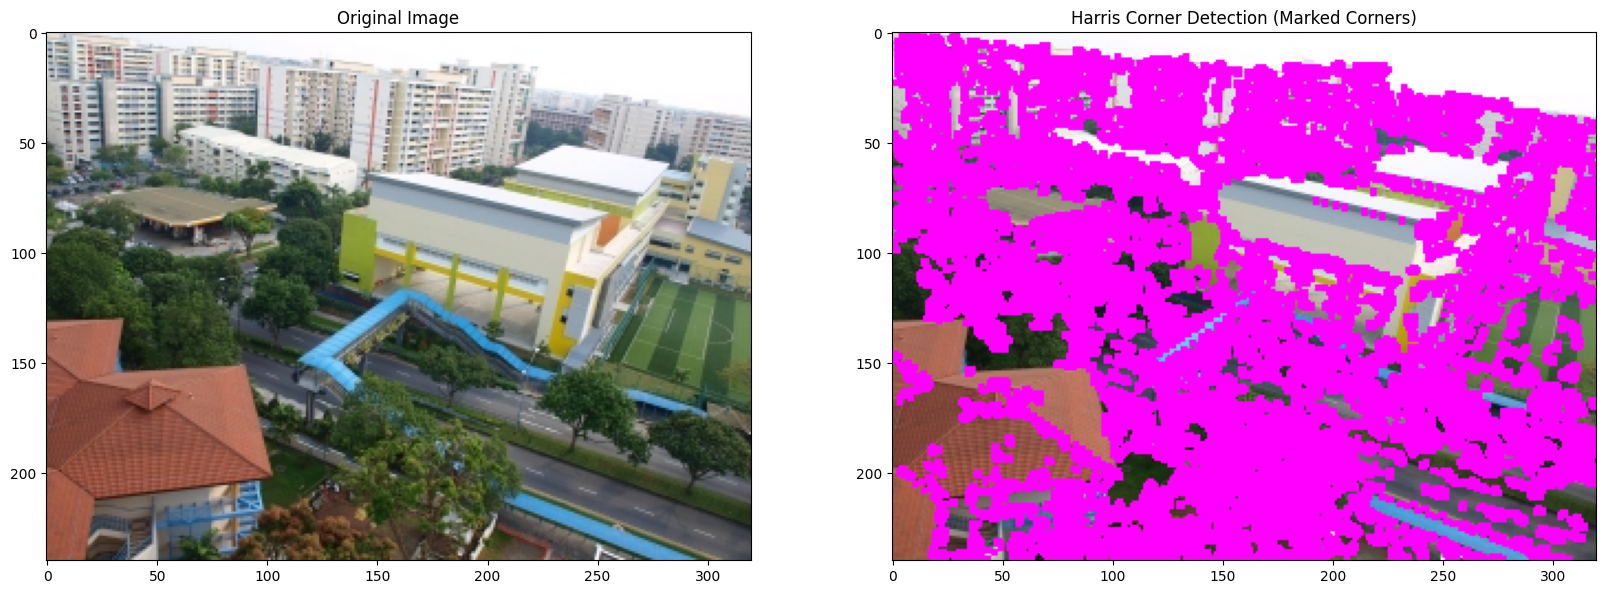

In [7]:
## your code goes here!!
img = cv.imread('assets/a.jpg')

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_gray, 50, 150, L2gradient=False)
edges_float = np.float32(edges)

harris_response = cv.cornerHarris(edges_float, blockSize=2, ksize=3, k=0.04)
harris_response = cv.dilate(harris_response, None)

img_corners = img.copy()

img_corners[harris_response > 0.01 * harris_response.max()] = [255, 0, 255]

plt.figure(figsize=(20, 18)) 
plt.subplot(121), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(122), plt.imshow(cv.cvtColor(img_corners, cv.COLOR_BGR2RGB))
plt.title('Harris Corner Detection (Marked Corners)')
plt.show()

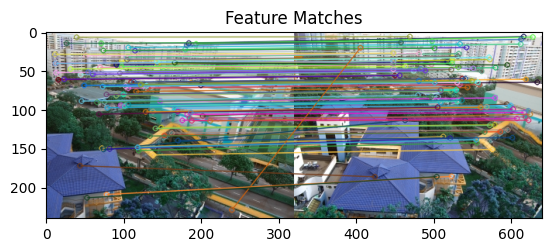

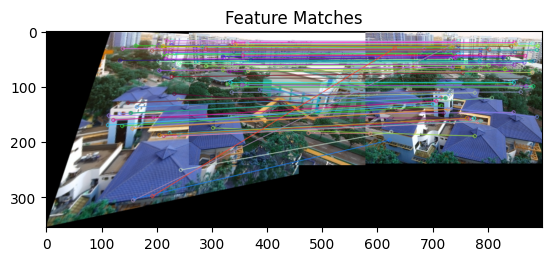

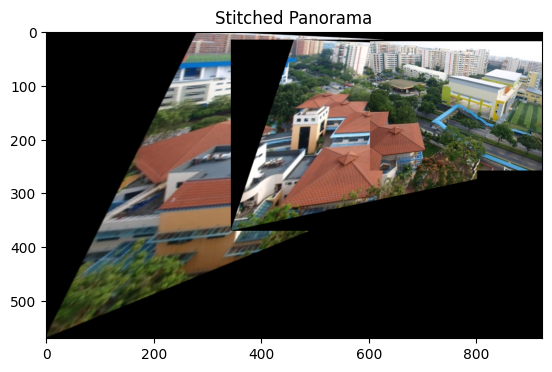

In [8]:
## your code goes here!!
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class PanoramaStitcher:
    def __init__(self):
        # Initialize SIFT detector
        self.sift = cv.SIFT_create()

    def detect_and_compute(self, img):
        """
        Detect keypoints and compute descriptors for the given image.
        """
        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Detect keypoints and compute descriptors
        keypoints, descriptors = self.sift.detectAndCompute(gray, None)
        
        # Return keypoints and descriptors
        return keypoints, descriptors

    def match_features(self, descriptors1, descriptors2):
        """
        Match features between two sets of descriptors.
        """
        # Initialize BFMatcher with default parameters
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

        # Match descriptors
        matches = bf.match(descriptors1, descriptors2)

        # Sort them in the order of their distance (best matches first)
        matches = sorted(matches, key=lambda x: x.distance)

        return matches

    def stitch_two_images(self, img1, img2):
        """
        Stitch two images together based on feature matching.
        """
        # Detect and compute keypoints and descriptors for both images
        keypoints1, descriptors1 = self.detect_and_compute(img1)
        keypoints2, descriptors2 = self.detect_and_compute(img2)

        # Match features between the two sets of descriptors
        matches = self.match_features(descriptors1, descriptors2)

        # Visualize matches between the two images
        img_matches = cv.drawMatches(img1, keypoints1, img2, keypoints2, matches[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img_matches)
        plt.title("Feature Matches")
        plt.show()

        # Extract location of good matches (keypoints from both images)
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Calculate the Homography matrix between the two sets of points
        H, mask = cv.findHomography(points2, points1, cv.RANSAC)

        # Warp the second image to align with the first image
        height1, width1, _ = img1.shape
        height2, width2, _ = img2.shape

        # Determine the size of the final panorama by warping img2 and calculating dimensions
        corners_img2 = np.array([[0, 0], [0, height2], [width2, height2], [width2, 0]], dtype=np.float32)
        warped_corners_img2 = cv.perspectiveTransform(np.array([corners_img2]), H)[0]

        # Calculate the size of the resulting stitched image
        min_x = int(min(0, warped_corners_img2[:, 0].min()))
        min_y = int(min(0, warped_corners_img2[:, 1].min()))
        max_x = int(max(width1, warped_corners_img2[:, 0].max()))
        max_y = int(max(height1, warped_corners_img2[:, 1].max()))

        # Offset translation to shift everything to positive coordinates if needed
        translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

        # Adjust the homography to consider the translation
        H_translation = np.dot(translation, H)

        # Warp img2 to create the panorama
        panorama_width = int(max_x - min_x)
        panorama_height = int(max_y - min_y)
        img2_aligned = cv.warpPerspective(img2, H_translation, (panorama_width, panorama_height))

        # Paste img1 into the resulting panorama
        img2_aligned[-min_y:height1 - min_y, -min_x:width1 - min_x] = img1

        # Return the stitched image (panorama)
        return img2_aligned

    def stitch_images(self, img1, img2, img3):
        """
        Stitch three images together sequentially.
        """
        # Stitch the first two images
        stitched = self.stitch_two_images(img1, img2)

        # Stitch the resulting image with the third image
        final_panorama = self.stitch_two_images(stitched, img3)

        return final_panorama

# Load your two images with overlapping fields of view
img1 = cv.imread('assets/a.jpg')  
img2 = cv.imread('assets/b.jpg')  
img3 = cv.imread('assets/c.jpg')

# Initialize the panorama stitcher
stitcher = PanoramaStitcher()

# Stitch the two images together
panorama = stitcher.stitch_images(img1, img2, img3)

# Show the final stitched panorama
plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
plt.title("Stitched Panorama")
plt.show()
